# Breast Cancer Classification

This exercise uses <a href="https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM#385f2cd4e86f4142b1d32bdb5803bd96"> the CBIS-DDSM (Curated Breast Imaging Subset of DDSM) dataset</a>. For the purpose of working on deep learning models regarding the csv files, we focus on two below datasets, which contain several features related to Mammography and dectection of breast cancer. 

Mass-Training-Description (csv)	
Mass-Test-Description (csv)	


The Mass-Training-Description and Mass-Test-Description include these columns:

patient_id	
breast_density	
left or right breast	
image view		
abnormality id		
abnormality type	
mass shape	
mass margins	
assessment	
pathology

There is more data in this dataset, including images, but for this homework we will not focus on them.

We are interested in this question:	
Using variables:	

breast_density	
left or right breast	
image view		
abnormality id		
abnormality type	
mass shape	
mass margins	

The goal of this exercise is to predict the **pathology type**



### Data Preparation

The output of your script should be a matrix X and a vector Y, where each row of X are one set of variables for a patient, and each row of Y is the pathology type class, for that patient.	

Use *matplotlib.imshow* to visualize the X.	
(And if there are multiple equivalent rows per patient, keep only one of them - any, up to you)


In [157]:
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pylab as plt
from torch.utils.data import Dataset, DataLoader
import copy
from tqdm import tqdm
import torch.optim.lr_scheduler as sched
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score, roc_curve


### Load Data

#### Method 1: Manually loading data using a load function

In [234]:
traindata = pd.read_csv('mass_case_description_train_set.csv')
testdata = pd.read_csv('mass_case_description_test_set.csv')

train_objs_num = len(traindata)
dataset = pd.concat(objs=[traindata, testdata], axis=0)

datasetx = dataset[['breast_density', 'left or right breast', 'image view', 'abnormality id', 'abnormality type', 'mass shape', 'mass margins']]
datasety = dataset[['pathology']]

dataset_preprocessed_x = pd.get_dummies(datasetx)
dataset_preprocessed_y = pd.get_dummies(datasety)

train_preprocessed_x = dataset_preprocessed_x[:train_objs_num]
train_preprocessed_y = dataset_preprocessed_y[:train_objs_num]
test_preprocessed_x = dataset_preprocessed_x[train_objs_num:]
test_preprocessed_y = dataset_preprocessed_y[train_objs_num:]


def load_data(xintermed, yintermed):
    x = xintermed.as_matrix().astype(float)
    y = yintermed.as_matrix().argmax(axis=1).astype(np.int64).reshape(-1,1)
    return x, y

xtrain, ytrain = load_data(train_preprocessed_x, train_preprocessed_y)
xtest, ytest = load_data(test_preprocessed_x, test_preprocessed_y)

#### Method 2: Using torch DataSet and DataLoader

In [246]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class MyDataset(Dataset):
    
    def __init__(self, size, inputdf, labeldf):
        super(MyDataset, self).__init__()
        self.size = size
        self.inputdf = inputdf
        self.labeldf = labeldf
        
    def __len__(self):
        return self.size

    def __getitem__(self, index):
        x = Variable(torch.from_numpy(self.inputdf.iloc[index,:].as_matrix().astype(float)))
        # we want y to be in this format tensor(1) for 1 being class
        y = torch.LongTensor(self.labeldf.iloc[index, :].as_matrix()).argmax()

                             
        return x, y

In [248]:
test_preprocessed_y

,pathology_BENIGN,pathology_BENIGN_WITHOUT_CALLBACK,pathology_MALIGNANT
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,1,0,0
...,...,...,...
373,0,1,0
374,0,0,1
375,0,0,1
376,0,0,1


In [249]:
data_train = MyDataset(train_objs_num, train_preprocessed_x, train_preprocessed_y)
data_test = MyDataset(len(testdata), test_preprocessed_x, test_preprocessed_y)

data_train_loader = DataLoader(data_train, batch_size = 64, shuffle=False, num_workers=4)
data_test_loader = DataLoader(data_test, batch_size = 64, shuffle=False, num_workers=4)

**Note**: Check to make sure that the two methods match by looking at the first x and y of the train dataset

In [250]:
x, y = next(iter(data_test_loader))
print(x)
print(y)

tensor([[4., 1., 1.,  ..., 0., 0., 1.],
        [4., 1., 1.,  ..., 0., 0., 1.],
        [2., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [2., 1., 0.,  ..., 0., 0., 0.],
        [2., 1., 0.,  ..., 0., 0., 0.],
        [2., 1., 1.,  ..., 0., 0., 1.]], dtype=torch.float64)
tensor([2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0,
        0, 0, 2, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1,
        1, 1, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2])


In [251]:
ytest[:64]

array([[2],
       [2],
       [2],
       [2],
       [0],
       [0],
       [2],
       [2],
       [0],
       [2],
       [2],
       [0],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [0],
       [0],
       [2],
       [2],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2]])

**Takeaways**
1. By using the DataLoader class, we already have input (x) and true label(y) as tensor. For the first method, we need to change x and y to tensors before feeding through the model.

### Modeling

#### 1. Linear Model

In [138]:
class LogReg(nn.Module):
    def __init__(self):
        super(LogReg, self).__init__()
        self.linear = nn.Linear(in_features=46, out_features=3)
        
    def forward(self, x):
        x = x.contiguous().view(-1, 46)
        # return logits
        x = self.linear(x)
        return x
    
logreg_model = LogReg().double()
    

#### 2. Multi-perceptron Model

In [66]:
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(46, 100)
        self.fc2 = nn.Linear(100, 3)


    def forward(self, x):
        x = x.contiguous().view(-1,46)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
mlpnet_model = MLPNet().double()

In [90]:
for iter_, (x, y_true) in enumerate(data_train_loader):
    print(iter_)
    break

0


### Training

In [255]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)


model = mlpnet_model

losslisttrain = []
losslisttest = []
best_val_loss = 100

for epoch in range(100):
    print('Epoch {}'.format(epoch))
    
    y_true_list_train = []
    y_score_list_train = [] # score of the malignant class - class 2
    y_true_list_test = []
    y_score_list_test = [] # score of the malignant class - class 2
    
    best_weights = copy.deepcopy(model.state_dict())
    model.train()

    cur_loss = 0
#     with torch.enable_grad(), \
#         tqdm(total=len(data_train_loader)) as progress_bar:
    for iter_, (x, y_true) in enumerate(data_train_loader):

        if iter_ % 10:
            print(f'Train Phase:  Iteration {iter_+1}/{len(data_train_loader)}', end="\r")

        # zero out the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):

            # Setup for forward
            x = x.to(device)
            y_true = y_true.to(device)
            batch_size = x.size(0)
            optimizer.zero_grad()

            # Feed forward to get the logits
            logit = model(x)
            loss = criterion(logit, y_true)
            loss_val = loss.item()
            cur_loss += loss_val * batch_size
            #print('cur_loss', cur_loss)

            # Add y_true and y_pred to list to calculate AUC score
            y_true_list_train += y_true.data.tolist()
            y_pred = logit.data.numpy().ravel()[2]
            y_score_list_train += logit.data.numpy()[:, 2].tolist()

        # Backward
        loss.backward()
        optimizer.step()

#             progress_bar.update(batch_size)
#             progress_bar.set_postfix(epoch=epoch,
#                          NLL=loss_val)


    avg_train_loss = cur_loss / len(data_train)
    losslisttrain.append(avg_train_loss)
    # get the auc
    train_auc =  roc_auc_score(y_true=(np.array(y_true_list)==2), y_score=np.array(y_score_list))


    print(f'Train Loss: {avg_train_loss:.4f}')
    print(f'Train AUC: {train_auc:.4f}')


    ######### Evaluation #####

    val_loss = 0

    for iter_, (x, y_true) in enumerate(data_test_loader):
        if iter_ % 10:
            print(f'Test Phase:  Iteration {iter_+1}/{len(data_test_loader)}', end="\r")
        # Setup for forward
        x = x.to(device)
        y_true = y_true.to(device)
        batch_size = x.size(0)

        # Feed forward to get the logits
        logit = model(x)
        loss = criterion(logit, y_true)
        loss_val = loss.item()
        val_loss += loss_val * batch_size
        #print('cur_loss', cur_loss)

        # Add y_true and y_pred to list to calculate AUC score
        y_true_list_test += y_true.data.tolist()
        y_pred = logit.data.numpy().ravel()[2]
        y_score_list_test += logit.data.numpy()[:, 2].tolist()

    avg_val_loss = cur_loss / len(data_test)
    losslisttest.append(avg_val_loss)
    # get the auc
    val_auc =  roc_auc_score(y_true=(np.array(y_true_list_test)==2),
                             y_score=np.array(y_score_list_test))


    print(f'Val Loss: {avg_val_loss:.4f}')
    print(f'Val AUC: {val_auc:.4f}')


    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_weights = copy.deepcopy(model.state_dict())

#             torch.save({
#             'state_dict': EncoderTransformer_model.state_dict()
#                 }, f'./chat_EncoderTransformer_model_best_{epoch}.pt')

Epoch 0
Train Loss: 0.3465ation 20/21
Train AUC: 0.8827
Val Loss: 1.2083ration 6/6
Val AUC: 0.7421
Epoch 1
Train Loss: 0.3454ation 20/21
Train AUC: 0.8827
Val Loss: 1.2043ration 6/6
Val AUC: 0.7413
Epoch 2
Train Loss: 0.3455ation 20/21
Train AUC: 0.8827
Val Loss: 1.2048ration 6/6
Val AUC: 0.7415
Epoch 3
Train Loss: 0.3455ation 20/21
Train AUC: 0.8827
Val Loss: 1.2048ration 6/6
Val AUC: 0.7414
Epoch 4
Train Loss: 0.3455ation 20/21
Train AUC: 0.8827
Val Loss: 1.2046ration 6/6
Val AUC: 0.7418
Epoch 5
Train Loss: 0.3454ation 20/21
Train AUC: 0.8827
Val Loss: 1.2045ration 6/6
Val AUC: 0.7413
Epoch 6
Train Loss: 0.3453ation 20/21
Train AUC: 0.8827
Val Loss: 1.2040ration 6/6
Val AUC: 0.7400
Epoch 7
Train Loss: 0.3453ation 20/21
Train AUC: 0.8827
Val Loss: 1.2040ration 6/6
Val AUC: 0.7403
Epoch 8
Train Loss: 0.3452ation 20/21
Train AUC: 0.8827
Val Loss: 1.2035ration 6/6
Val AUC: 0.7403
Epoch 9
Train Loss: 0.3452ation 20/21
Train AUC: 0.8827
Val Loss: 1.2035ration 6/6
Val AUC: 0.7407
Epoch 10
T

Train Loss: 0.3408ation 20/21
Train AUC: 0.8827
Val Loss: 1.1883ration 6/6
Val AUC: 0.7372
Epoch 83
Train Loss: 0.3408ation 20/21
Train AUC: 0.8827
Val Loss: 1.1882ration 6/6
Val AUC: 0.7389
Epoch 84
Train Loss: 0.3406ation 20/21
Train AUC: 0.8827
Val Loss: 1.1877ration 6/6
Val AUC: 0.7387
Epoch 85
Train Loss: 0.3407ation 20/21
Train AUC: 0.8827
Val Loss: 1.1880ration 6/6
Val AUC: 0.7388
Epoch 86
Train Loss: 0.3405ation 20/21
Train AUC: 0.8827
Val Loss: 1.1873ration 6/6
Val AUC: 0.7372
Epoch 87
Train Loss: 0.3406ation 20/21
Train AUC: 0.8827
Val Loss: 1.1877ration 6/6
Val AUC: 0.7389
Epoch 88
Train Loss: 0.3404ation 20/21
Train AUC: 0.8827
Val Loss: 1.1868ration 6/6
Val AUC: 0.7376
Epoch 89
Train Loss: 0.3405ation 20/21
Train AUC: 0.8827
Val Loss: 1.1871ration 6/6
Val AUC: 0.7384
Epoch 90
Train Loss: 0.3404ation 20/21
Train AUC: 0.8827
Val Loss: 1.1870ration 6/6
Val AUC: 0.7372
Epoch 91
Train Loss: 0.3405ation 20/21
Train AUC: 0.8827
Val Loss: 1.1871ration 6/6
Val AUC: 0.7381
Epoch 92


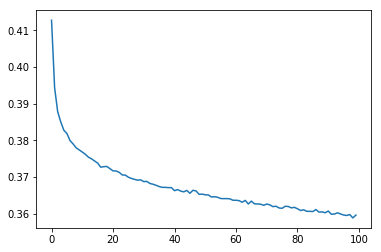

In [208]:
plt.plot(losslisttrain); plt.show()

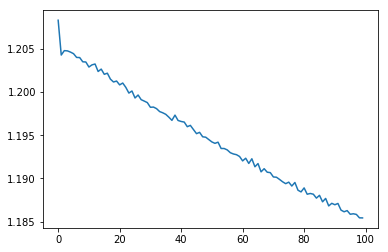

In [256]:
plt.plot(losslisttest); plt.show()

avg train loss is 0.776403496951455
AUC train is: 0.7864876889420628
avg test loss is 0.7776630283078922
AUC test is: 0.8185646552993492
avg train loss is 0.5991981001728873
AUC train is: 0.866571230322017
avg test loss is 0.7162172816104658
AUC test is: 0.8013517095149748
avg train loss is 0.5701754389219945
AUC train is: 0.8771314693278192
avg test loss is 0.8705279775899837
AUC test is: 0.8321995464852608
avg train loss is 0.5539195132282319
AUC train is: 0.8753218671406211
avg test loss is 0.8051292415811628
AUC test is: 0.8079630120446447
avg train loss is 0.532216925558927
AUC train is: 0.8830743412241209
avg test loss is 0.8935109759492686
AUC test is: 0.7853019995877137
avg train loss is 0.5250603675317184
AUC train is: 0.8791347104751762
avg test loss is 0.7733848489354538
AUC test is: 0.7741555496657537
avg train loss is 0.5130061578969705
AUC train is: 0.8903657701643857
avg test loss is 0.8989206913495543
AUC test is: 0.813131313131313
avg train loss is 0.531116944657561
AU

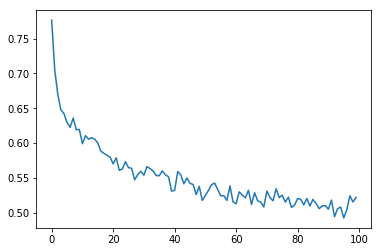

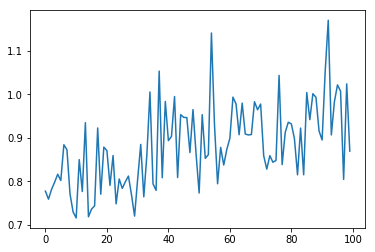

In [217]:
model = MLPNet().double()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
from sklearn.metrics import roc_auc_score

losslisttrain = []
losslisttest = []

for epoch in range(100):
    avg_loss = 0
    ix_shuffle = np.arange(xtrain.shape[0])
    np.random.shuffle(ix_shuffle)
    ypred =  np.zeros(ytrain.shape)
    for ix in ix_shuffle:
        optimizer.zero_grad()
        x = Variable(torch.from_numpy(xtrain[ix]))
        target = Variable(torch.LongTensor(ytrain[ix]))
        out = model(x)
        ypred[ix] = out.data.numpy().ravel()[2]
        loss = criterion(out, target)
        avg_loss += loss.data.numpy().ravel()[0]
        loss.backward()
        optimizer.step()
    losslisttrain.append(avg_loss/xtrain.shape[0])
    if epoch % 10 == 0:
        print('avg train loss is', avg_loss/xtrain.shape[0])
        print('AUC train is:', roc_auc_score(y_true=(ytrain==2), y_score=ypred))

    ix_shuffle = np.arange(xtest.shape[0])
    np.random.shuffle(ix_shuffle)
    avg_loss = 0
    ypredtest = np.zeros(ytest.shape)
    for ix in ix_shuffle:
        x = Variable(torch.from_numpy(xtest[ix]))
        target = Variable(torch.LongTensor(ytest[ix]))
        out = model(x)
        ypredtest[ix] = out.data.numpy().ravel()[2]
        loss = criterion(out, target)
        avg_loss += loss.data.numpy().ravel()[0]
    losslisttest.append(avg_loss/xtest.shape[0])
    if epoch % 10 == 0:
        print('avg test loss is', avg_loss/xtest.shape[0])
        print('AUC test is:', roc_auc_score(y_true=(ytest==2), y_score=ypredtest))

plt.plot(losslisttrain); plt.show()
plt.plot(losslisttest); plt.show()